In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
#Reading the csv and converting to a dataframe
dataset = pd.read_csv('car_price.csv')

#kmpl to km/kg
clist = []
count = 0
for object in dataset['mileage']:
  newobject = str(object)
  if re.search(r'\b' + "kmpl" + r'\b', newobject):
    clist.append(count)
  count = count + 1

#Dropping letters of the units
dataset['mileage'] = (dataset['mileage'].str.rstrip(' kmplkg/km')).astype(float)

isDiesel = []
isPetrol = []
#Converting kmpl to km/kg
for count in clist:
  if dataset.at[count, 'fuel'] == 'Diesel':
    dataset.at[count, 'mileage'] = (dataset.at[count, 'mileage'])/0.832
    isDiesel.append(count)#This is a surprise tool that will help us later
  elif dataset.at[count, 'fuel'] == 'Petrol':
    dataset.at[count, 'mileage'] = (dataset.at[count, 'mileage'])/0.742
    isPetrol.append(count)#''

#Drop... cont.
dataset['engine'] = (dataset['engine'].str.rstrip(' CC')).astype(float)

#THROWS ERROR AT ENTRY NO. 4933 because only bhp is written at that place
dataset['max_power'] = dataset['max_power'].str.rstrip(' bhp')

count = 0
for object in dataset['max_power']:
  if count != 4933:
    object = (float)(object)
    dataset.at[count, 'max_power'] = object
  count = count + 1

dataset.at[4933, 'max_power'] = np.nan

print(dataset)

                              name  year  ...                     torque  seats
0           Maruti Swift Dzire VDI  2014  ...             190Nm@ 2000rpm    5.0
1     Skoda Rapid 1.5 TDI Ambition  2014  ...        250Nm@ 1500-2500rpm    5.0
2         Honda City 2017-2020 EXi  2006  ...      12.7@ 2,700(kgm@ rpm)    5.0
3        Hyundai i20 Sportz Diesel  2010  ...   22.4 kgm at 1750-2750rpm    5.0
4           Maruti Swift VXI BSIII  2007  ...      11.5@ 4,500(kgm@ rpm)    5.0
...                            ...   ...  ...                        ...    ...
8123             Hyundai i20 Magna  2013  ...           113.7Nm@ 4000rpm    5.0
8124         Hyundai Verna CRDi SX  2007  ...  24@ 1,900-2,750(kgm@ rpm)    5.0
8125        Maruti Swift Dzire ZDi  2009  ...             190Nm@ 2000rpm    5.0
8126               Tata Indigo CR4  2013  ...        140Nm@ 1800-3000rpm    5.0
8127               Tata Indigo CR4  2013  ...        140Nm@ 1800-3000rpm    5.0

[8128 rows x 13 columns]


In [3]:
#Taking the torque values and splitting them into Nm and avg. RPM
count = 0

#keeping track of kgm values
clist2 = []

#Used to make 2 new columns
torqlist = []
rpmlist = []
for object in dataset['torque']:
  newobject = str(object)
  if re.search(r'\b' + "kgm" + r'\b', newobject):
    clist2.append(count)
  count = count + 1
  newobject = newobject.replace(',', '')
  A = re.findall(r"[-+]?\d*\.\d+|\d+", newobject)
  leng = len(A)
  if leng == 0:
    torqlist.append(np.nan)
    rpmlist.append(np.nan)
    continue
  elif leng == 1:
    a0 = float(A[0])
    torqlist.append(a0)
    rpmlist.append(np.nan)
  elif leng == 2:
    a0 = float(A[0])
    a1 = float(A[1])
    torqlist.append(a0)
    rpmlist.append(a1)
  elif leng == 3:
    a0 = float(A[0])
    a1 = float(A[1])
    a2 = float(A[2])
    torqlist.append(a0)
    rpmlist.append((a1+a2)/2) #Why average? Asked my mechanical friend

#kgm to Nm
for index in clist2:
  torqlist[index] = torqlist[index]*9.80665

dataset['NM'] = torqlist
dataset['RPM'] = rpmlist
del dataset['torque']

dataset = dataset.replace(np.nan, 0)
print(dataset.iloc[13, :])

#Preparation of Features and Results
X = dataset.loc[:, dataset.columns != 'selling_price'].values
X = X[:, 1:]
Y = dataset.iloc[:, 2].values
print(X)
print(Y)

name             Maruti Swift 1.3 VXi
year                             2007
selling_price                  200000
km_driven                       80000
fuel                           Petrol
seller_type                Individual
transmission                   Manual
owner                    Second Owner
mileage                             0
engine                              0
max_power                           0
seats                               0
NM                                  0
RPM                                 0
Name: 13, dtype: object
[[2014 145500 'Diesel' ... 5.0 190.0 2000.0]
 [2014 120000 'Diesel' ... 5.0 250.0 2000.0]
 [2006 140000 'Petrol' ... 5.0 124.54445499999999 2700.0]
 ...
 [2009 120000 'Diesel' ... 5.0 190.0 2000.0]
 [2013 25000 'Diesel' ... 5.0 140.0 2400.0]
 [2013 25000 'Diesel' ... 5.0 140.0 2400.0]]
[450000 370000 158000 ... 382000 290000 290000]


In [4]:
print(X[13,:])

[2007 80000 'Petrol' 'Individual' 'Manual' 'Second Owner' 0.0 0.0 0.0 0.0
 0.0 0.0]


In [5]:
'''
There are nan values above that need to be fixed.
So, we'll replace them with the mean values of Petrol and Diesel respectively.
Index of mileage is 6, engine 7, max_power 8, seats 9, NM 10 and RPM 11
'''
isCNG = []
isLPG = []

for i in range(len(X)):
  if dataset.at[i, 'fuel'] == 'CNG':
    isCNG.append(i)
  elif dataset.at[i, 'fuel'] == 'LPG':
    isLPG.append(i)

mean_Diesel = []
mean_Petrol = []
mean_CNG = []
mean_LPG = []

for j in range(6,12):
  mean = 0
  for index in isDiesel:
      mean = mean + X[index][j]
  mean_Diesel.append(mean/len(isDiesel))


for j in range(6,12):
  mean = 0
  for index in isPetrol:
    mean = mean + X[index][j]
  mean_Petrol.append(mean/len(isPetrol))


for j in range(6,12):
  mean = 0
  for index in isCNG:
    mean = mean + X[index][j]
  mean_CNG.append(mean/len(isCNG))

for j in range(6,12):
  mean = 0
  for index in isLPG:
    mean = mean + X[index][j]
  mean_LPG.append(mean/len(isLPG))

count = 0

for j in range(6,12):
  for index in range(len(X)):
    if X[index][j] == 0 and X[index][2] == 'Petrol':
      X[index][j] = mean_Petrol[count]
    elif X[index][j] == 0 and X[index][2] == 'Diesel':
      X[index][j] = mean_Diesel[count]
    elif X[index][j] == 0 and X[index][2] == 'CNG':
      X[index][j] = mean_CNG[count]
    elif X[index][j] == 0 and X[index][2] == 'LPG':
      X[index][j] = mean_LPG[count]
  count = count + 1

In [6]:
print(X[13,:])
print(X[78,:])

[2007 80000 'Petrol' 'Individual' 'Manual' 'Second Owner'
 25.717386976231385 1182.4457386363636 80.1722443181807 5.046590909090909
 113.81890364204554 3813.4280113636364]
[2003 70000 'Diesel' 'Individual' 'Manual' 'First Owner'
 23.608922915883824 1692.8813677599442 101.56669806931819
 5.728076296813212 236.08581429518506 2092.9359967434284]


In [7]:
print(len(isDiesel), len(isPetrol), len(isLPG), len(isCNG))

4299 3520 38 57


In [8]:
#Encoding

def Encoding(X):
  '''
  Automatic - 1
  Manual - 0
  '''
  man = []
  aut = []

  for index in range(len(X)):
    if X[index][4] == 'Manual':
      man.append(index)
      X[index][4] = 0
    else:
      aut.append(index)
      X[index][4] = 1

  '''
  Individual - 0
  Dealer - 1
  Trustmark Dealer - 2
  Self Explanatory
  '''
  ind = []
  dea = []
  td = []

  for index in range(len(X)):
    if X[index][3] == 'Individual':
      ind.append(index)
      X[index][3] = 0
    elif X[index][3] == 'Dealer':
      dea.append(index)
      X[index][3] = 1
    elif X[index][3] == 'Trustmark Dealer':
      td.append(index)
      X[index][3] = 2

  '''
  Test Drive Car = 4
  First Owner = 3
  2nd Owner = 2
  3rd Owner = 1
  4th Owner = 0
  Self Explanatory
  '''
  fourth = []
  third = []
  second = []
  first = []
  test = []

  for index in range(len(X)):
    if X[index][5] == 'Fourth & Above Owner':
      fourth.append(index)
      X[index][5] = 0
    elif X[index][5] == 'Third Owner':
      third.append(index)
      X[index][5] = 1
    elif X[index][5] == 'Second Owner':
      second.append(index)
      X[index][5] = 2
    elif X[index][5] == 'First Owner':
      first.append(index)
      X[index][5] = 3
    elif X[index][5] == 'Test Drive Car':
      test.append(index)
      X[index][5] = 4

  for index in range(len(X)):
    if X[index][2] == 'LPG':
      X[index][2] = 0
    elif X[index][2] == 'CNG':
      X[index][2] = 1
    elif X[index][2] == 'Petrol':
      X[index][2] = 2
    elif X[index][2] == 'Diesel':
      X[index][2] = 3
  return X

In [9]:
X = Encoding(X)

In [10]:
#Preparation of Matrix

def prepMat(X):
  new_column = np.ones(len(X))
  X = np.insert(X, 0, new_column, axis=1)
  return X

X = prepMat(X)
print(X[4933, :])

[1.0 2000 100000 1 0 0 2 10.9 796.0 55.64280701754386 8.0
 76.39794956140351 3013.157894736842]


8128


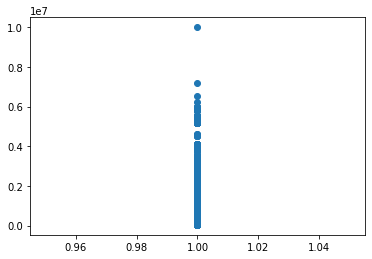

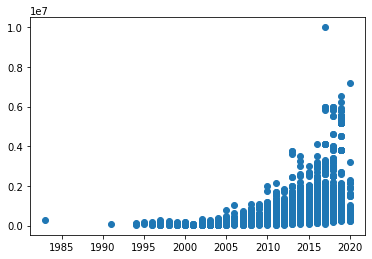

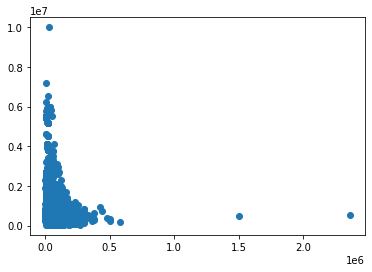

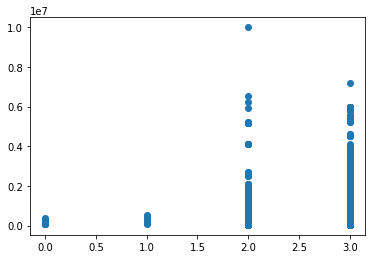

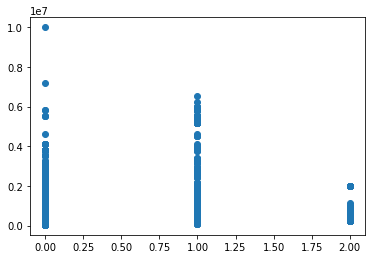

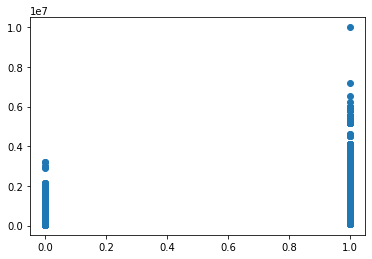

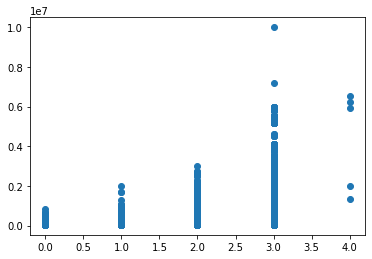

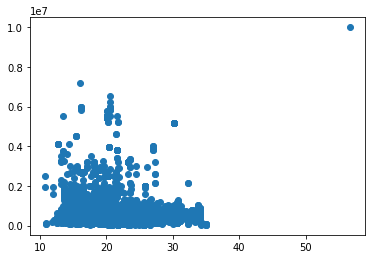

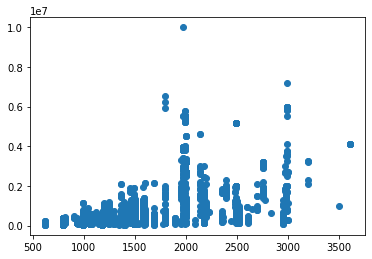

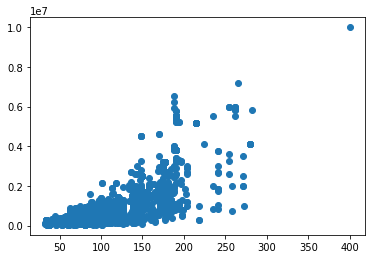

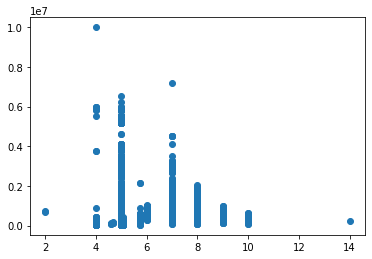

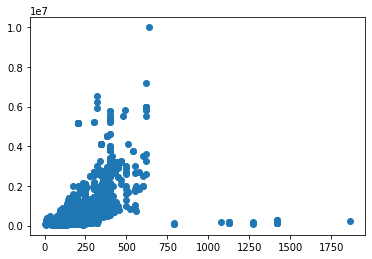

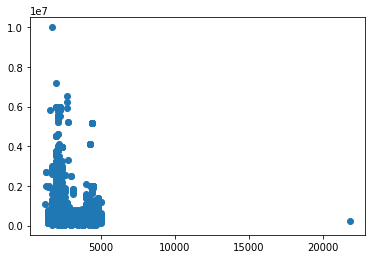

In [11]:
#Analysis of Data
points = []

for j in range(len(X[0, :])):
  lop = []
  for i in range(len(X)):
    lop.append(X[i][j])
  points.append(lop)

print(len(points[0]))

for j in range(13):
  plt.scatter(points[j], Y)
  plt.show()

#1, 2, 7, 8, 9, 10, 11, 12 need squaring, Lets try cubing 7 and 12

square = [1, 2, 8, 9, 11]
cube = [7, 12]

In [12]:
def AddFeatures(X):
  for index in square:
    decoy = X[:, index]
    decoy = np.square(decoy)
    X = np.column_stack((X, decoy))

  for index in cube:
    decoy = X[:, index]
    decoy = np.power(decoy, 3)
    X = np.column_stack((X, decoy))
  return X

X = AddFeatures(X)
print(X)

[[1.0 2014 145500 ... 36100.0 22247.314453125 8000000000.0]
 [1.0 2014 120000 ... 62500.0 16403.819053347783 8000000000.0]
 [1.0 2006 140000 ... 15511.321271247021 13574.007451040989 19683000000.0]
 ...
 [1.0 2009 120000 ... 36100.0 12482.510732964167 8000000000.0]
 [1.0 2013 25000 ... 19600.0 22735.72296330101 13824000000.0]
 [1.0 2013 25000 ... 19600.0 22735.72296330101 13824000000.0]]


In [13]:
#Splitting data

from sklearn.model_selection import train_test_split
X_train, X_tes, Y_train, Y_tes = train_test_split(X, Y, test_size = 0.4, random_state = 1)
X_val, X_test, Y_val, Y_test = train_test_split(X_tes, Y_tes, test_size = 0.5, random_state = 1)
print(X_train[1, :])

[1.0 2010 86017 3 1 0 2 30.649038461538463 1498.0 99.23 5.0 215.0 2375.0
 4040100 7398924289 2244004.0 9846.592900000001 46225.0 28790.589837415908
 13396484375.0]


In [14]:
#Model Training using Normal equation

decoy_X = (X_train.transpose()).astype('float')
prod1 = (np.matmul(decoy_X, X_train)).astype('float')
reg_matrix = np.zeros((len(X_train[0]), len(X_train[0])), float)
np.fill_diagonal(reg_matrix, 1)
reg_matrix[0][0] = 0.0
prod1 = prod1+0.01*reg_matrix
prod1 = np.linalg.inv(prod1)
prod2 = np.matmul(decoy_X,Y_train)

theta = np.matmul(prod1, prod2)

print(theta)

[ 1.52073396e+10 -1.51705143e+07 -1.05280752e+00 -3.21267500e+04
  1.25100257e+05  2.82865852e+05  5.12919491e+03  7.69189725e+04
  1.06926345e+03 -1.67053357e+04  2.11009497e+04 -1.34417366e+03
 -1.53942233e+02  3.78318704e+03  7.48076317e-07 -2.54352824e-01
  1.26437430e+02  9.15809135e-01 -3.81459125e+01  5.98998274e-07]


In [15]:
def predict(X, Y):
  final_array = np.zeros(len(Y))
  count = 0
  for object in X:
    j = 0
    final = 0
    for i in range(20):
      final = final + object[i]*theta[i]
    final_array[count] = final
    count = count+1
  return final_array

In [16]:
#Printing test cases predictions
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

final_array = predict(X_val, Y_val)
print(r2_score(Y_val, final_array))
print(1-(1-r2_score(Y_val, final_array))*((len(X_val)-1)/(len(X_val)-len(X_val[0])-1)))
rms = mean_squared_error(Y_val, final_array, squared=False)
print(rms)

final_array = predict(X_test, Y_test)
print(r2_score(Y_test, final_array))
print(1-(1-r2_score(Y_test, final_array))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))
rms = mean_squared_error(Y_test, final_array, squared=False)
print(rms)

0.7546059322994995
0.751548062297001
366401.5031860989
0.7939616966592107
0.7913942411658675
365279.071163208


In [17]:
#CHECKING FOR OVERFITTING

final_array = predict(X_train, Y_train)
print(r2_score(Y_train, final_array))
print(1-(1-r2_score(Y_train, final_array))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))
rms = mean_squared_error(Y_train, final_array, squared=False)
print(rms)

0.7705301117983083
0.7676706739390973
396375.32485221355


In [18]:
def predict_single(X):
  final_value = 0
  count = 0
  for object in X:
    j = 0
    final = 0
    for i in range(20):
      final = final + object[i]*theta[i]
    final_value = final
    count = count+1
  return final_value

In [23]:
X_val[53, :]
Y_val[53]

840000

In [24]:
#PREDICTOR

X_price_pred = np.array([[2019, 1500, 'Diesel', 'Individual','Manual','First Owner', 
                          24.528301886792452, 1199.0, 88.7, 5.0, 110.0, 4800.0]])

X_price_pred = Encoding(X_price_pred).astype(float)
X_price_pred = prepMat(X_price_pred)
X_price_pred = AddFeatures(X_price_pred)
print(X_price_pred)
print(predict_single(X_price_pred))

[[1.00000000e+00 2.01900000e+03 1.50000000e+03 3.00000000e+00
  0.00000000e+00 0.00000000e+00 3.00000000e+00 2.45283019e+01
  1.19900000e+03 8.87000000e+01 5.00000000e+00 1.10000000e+02
  4.80000000e+03 4.07636100e+06 2.25000000e+06 1.43760100e+06
  7.86769000e+03 1.21000000e+04 1.47571485e+04 1.10592000e+11]]
674020.2203807806
